# Problem Description :

### Importing the required packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import OLS
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor

### Setting the current working directory and loading the files

In [2]:
os.chdir("I:\DATA-SCIENCE\SalesForecasting")
sales_data = pd.read_csv("Train.csv")
holidays_data = pd.read_excel("Events_HolidaysData.xlsx")
economic_data = pd.read_excel("MacroEconomicData.xlsx")
weather_data_xlsx = pd.ExcelFile("WeatherData.xlsx")

### Defining the Error Metric to be used

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Basic Understanding of the Dataset

## 1.1 Sales Data

In [4]:
print("Datatypes of each columns :")
print(sales_data.dtypes)

Datatypes of each columns :
Year                           int64
Month                          int64
ProductCategory               object
Sales(In ThousandDollars)    float64
dtype: object


In [5]:
# Removing the instances of 'MenClothing' and 'OtherClothing' from sales data
sales_data = sales_data.loc[sales_data.ProductCategory == "WomenClothing" ,:]

In [6]:
print("The first 5 instances from the table:")
sales_data.head()

The first 5 instances from the table:


,Year,Month,ProductCategory,Sales(In ThousandDollars)
0,2009,1,WomenClothing,1755.0
3,2009,2,WomenClothing,1729.0
6,2009,3,WomenClothing,2256.0
9,2009,4,WomenClothing,2662.0
12,2009,5,WomenClothing,2732.0


In [7]:
print("The last 5 instances from the table:")
sales_data.tail()

The last 5 instances from the table:


,Year,Month,ProductCategory,Sales(In ThousandDollars)
237,2015,8,WomenClothing,3897.0
240,2015,9,WomenClothing,3881.0
243,2015,10,WomenClothing,4372.0
246,2015,11,WomenClothing,4401.0
249,2015,12,WomenClothing,5874.0


## 1.2 Holidays Data

In [8]:
print("Datatypes of each columns :")
print(holidays_data.dtypes)

Datatypes of each columns :
Year                    int64
MonthDate      datetime64[ns]
Event                  object
DayCategory            object
dtype: object


In [9]:
print("The first 2 instances from the table:")
holidays_data.head()

The first 2 instances from the table:


,Year,MonthDate,Event,DayCategory
0,2009,2001-01-01,New Year's Day,Federal Holiday
1,2009,2019-01-01,Martin Luther King Jr. Day,Federal Holiday
2,2009,2014-02-01,Valentine's Day,Event
3,2009,2016-02-01,Presidents' Day,Federal Holiday
4,2009,2012-04-01,Easter Sunday,Event


### 1.2.3 Modifying the "MonthDate" column

In [10]:
# Extracting the date and month from the 'MonthDate' column.
holidays_data.MonthDate = holidays_data.MonthDate.astype(str).str[2:7]

In [11]:
print("The first 5 instances from the table after processing:")
holidays_data.head()

The first 5 instances from the table after processing:


,Year,MonthDate,Event,DayCategory
0,2009,01-01,New Year's Day,Federal Holiday
1,2009,19-01,Martin Luther King Jr. Day,Federal Holiday
2,2009,14-02,Valentine's Day,Event
3,2009,16-02,Presidents' Day,Federal Holiday
4,2009,12-04,Easter Sunday,Event


In [12]:
print("The categories and their count in 'DayCategory' column:")
print(holidays_data.DayCategory.value_counts())

The categories and their count in 'DayCategory' column:
Federal Holiday    88
Event              62
Name: DayCategory, dtype: int64


In [13]:
print(holidays_data.Event.value_counts())

Martin Luther King Jr. Day     8
Labor Day                      8
Easter Sunday                  8
Thanksgiving Day               8
Columbus Day (Most regions)    8
Memorial Day                   8
New Year's Day                 8
Presidents' Day                8
Halloween                      8
Christmas Eve                  8
New Year's Eve                 8
Veterans Day                   8
Independence Day               8
Mother's Day                   8
Father's Day                   8
Valentine's Day                8
Christmas Day                  8
'Independence Day' observed    3
'Christmas Day' observed       3
Thomas Jefferson's Birthday    3
Election Day                   2
'New Year's Day' observed      2
Day After Christmas Day        1
Name: Event, dtype: int64


## 1.3 Macroeconimic Data

In [14]:
print("Datatypes of each columns :")
print(economic_data.dtypes)

Datatypes of each columns :
Year-Month                                                            object
Monthly Nominal GDP Index (inMillion$)                               float64
Monthly Real GDP Index (inMillion$)                                  float64
CPI                                                                  float64
PartyInPower                                                          object
unemployment rate                                                    float64
CommercialBankInterestRateonCreditCardPlans                          float64
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan    float64
Earnings or wages  in dollars per hour                               float64
AdvertisingExpenses (in Thousand Dollars)                             object
Cotton Monthly Price - US cents per Pound(lbs)                       float64
Change(in%)                                                          float64
Average upland planted(million acres)           

In [15]:
# Printing the statistics of the macro economic table
economic_data.describe(include = 'all')

,Year-Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
count,96,96.000000,96.000000,96.000000,96,96.000000,96.000000,96.000000,96.000000,96,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
unique,96,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015 - Apr,NaN,NaN,NaN,Democrats,NaN,NaN,NaN,NaN,?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,96,NaN,NaN,NaN,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,16490.078125,15548.932194,252.372552,NaN,7.442708,12.519479,10.447604,23.793229,NaN,91.034479,0.615521,10.647698,8.851885,791.843750,14.616010,3.556104,11.061615
std,NaN,1427.554038,773.076316,9.290857,NaN,1.766397,0.722375,0.560651,1.147167,NaN,33.613974,6.919387,1.728418,1.102847,25.753621,2.007579,0.158263,1.710573
min,NaN,14317.372922,14345.676097,233.402000,NaN,4.600000,11.820000,9.450000,21.960000,NaN,51.500000,-23.590000,8.398000,7.345000,747.000000,11.751000,3.275000,8.500000
25%,NaN,15210.701514,14919.668252,242.474500,NaN,5.675000,11.950000,10.030000,22.797500,NaN,70.377500,-2.400000,9.296000,7.586000,772.750000,12.551000,3.410000,9.742500
50%,NaN,16422.454368,15442.996869,254.680500,NaN,7.750000,12.220000,10.470000,23.800000,NaN,83.905000,0.350000,10.260500,9.156500,790.000000,14.959000,3.572500,10.637500
75%,NaN,17772.032416,16262.237629,260.381500,NaN,9.000000,13.057500,10.940000,24.772500,NaN,93.322500,3.482500,11.412250,9.654500,807.000000,16.250000,3.675000,11.493750


In [16]:
economic_data.isnull().sum()

Year-Month                                                           0
Monthly Nominal GDP Index (inMillion$)                               0
Monthly Real GDP Index (inMillion$)                                  0
CPI                                                                  0
PartyInPower                                                         0
unemployment rate                                                    0
CommercialBankInterestRateonCreditCardPlans                          0
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan    0
Earnings or wages  in dollars per hour                               0
AdvertisingExpenses (in Thousand Dollars)                            0
Cotton Monthly Price - US cents per Pound(lbs)                       0
Change(in%)                                                          0
Average upland planted(million acres)                                0
Average upland harvested(million acres)                              0
yieldp

### 1.3.1 Categorical Variables

In [17]:
print(economic_data["PartyInPower"].value_counts(), "\n")
print("NOTE: The attribute 'PartyInPower' has only one category for all the instances and hence is not useful for the analysis.")

# Droping the column 'PartyInPower'
economic_data.drop('PartyInPower', axis=1,inplace=True)

Democrats    96
Name: PartyInPower, dtype: int64 

NOTE: The attribute 'PartyInPower' has only one category for all the instances and hence is not useful for the analysis.


In [18]:
print(economic_data["AdvertisingExpenses (in Thousand Dollars)"].value_counts(), "\n")
print("NOTE: The attribute 'AdvertisingExpenses (in Thousand Dollars)' has 88% of missing values which are denoted as '?'.")

# Droping the column 'AdvertisingExpenses (in Thousand Dollars)'
economic_data.drop('AdvertisingExpenses (in Thousand Dollars)', axis=1,inplace=True)

?      85
221     1
150     1
201     1
137     1
200     1
248     1
214     1
165     1
116     1
183     1
208     1
Name: AdvertisingExpenses (in Thousand Dollars), dtype: int64 

NOTE: The attribute 'AdvertisingExpenses (in Thousand Dollars)' has 88% of missing values which are denoted as '?'.


### 1.3.2 Numerical Variables

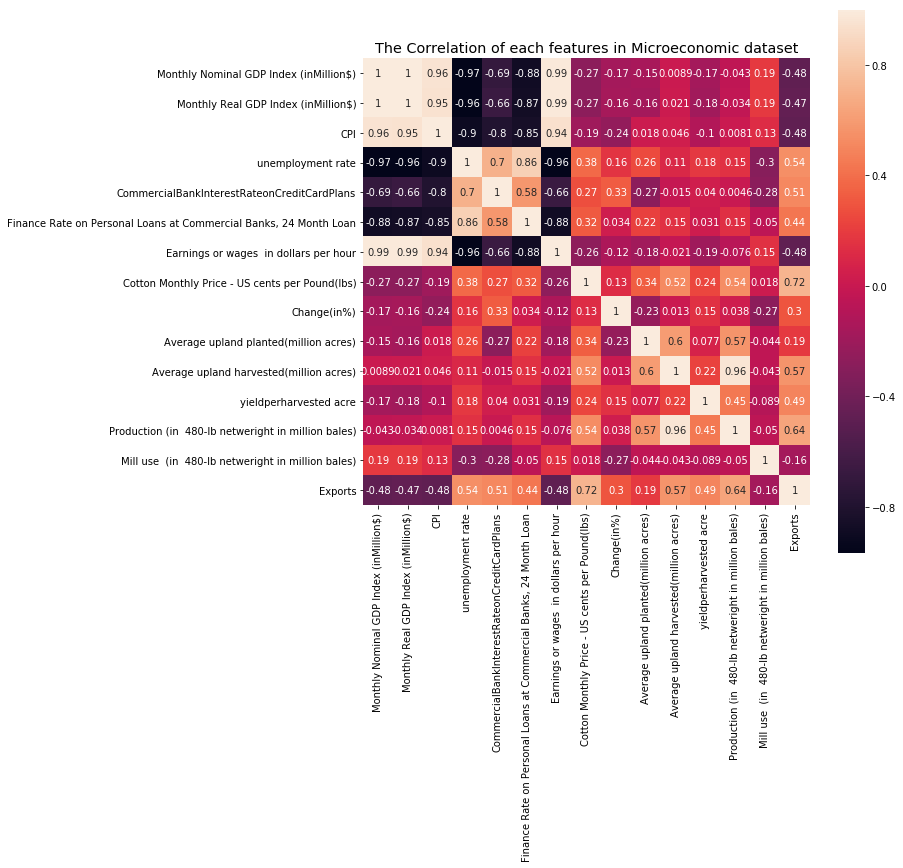

In [19]:
# Calculating the correlation of each variables
correlation = economic_data.corr()

### Ploting the correlation 
%matplotlib inline
plt.figure(figsize =(10,10))
sns.heatmap(data= correlation, annot =True, square= True)
plt.title('The Correlation of each features in Microeconomic dataset', fontsize= 'x-large')
plt.show()

## 1.4 Weather Data

### 1.4.1 Creating a single dataframe from the given tables.

In [20]:
# Adding each sheet from the excel file to a list of dataframes.
weather_data_list = []
for i in range(0,len(weather_data_xlsx.sheet_names)):
    weather_data_list.append(weather_data_xlsx.parse(weather_data_xlsx.sheet_names[i])) 
    
    # Setting the Year column with proper values
    weather_data_list[i].Year = weather_data_xlsx.sheet_names[i]

# Shifting each row one step upwards in the dataframe.
weather_data_list[5].loc[:,"Temp high (°C)":"WeatherEvent"] = weather_data_list[5].loc[:,"Temp high (°C)":"WeatherEvent"]\
.shift(-1)
weather_data_list[5] = weather_data_list[5][:-1].copy()

# Combining list of weather datas into a single dataframe
weather_data = pd.DataFrame()
for df in weather_data_list:
    weather_data = pd.concat([weather_data,df])
    

In [21]:
print("The first 5 instances from the table:")
weather_data.head()

The first 5 instances from the table:


,Year,Month,Day,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,...,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) low,Visibility (km) high,Visibility (km) avg,Visibility (km) low,Wind (km/h) low,Wind (km/h) avg,Wind (km/h) high,Precip. (mm) sum,WeatherEvent
0,2009,Jan,1.0,-3,-6,-9,-16,-17,-19,54,...,1023,1015,16,16,16,37,18,60,0,NaN
1,2009,Jan,2.0,1,-2,-5,-3,-7,-17,78,...,1012,1007,16,13,2,27,10,48,T,Snow
2,2009,Jan,3.0,3,1,-2,-5,-9,-13,72,...,1015,1008,16,16,16,27,16,42,T,NaN
3,2009,Jan,4.0,6,1,-4,-10,-12,-13,55,...,1017,1015,16,16,16,32,12,40,0,NaN
4,2009,Jan,5.0,6,5,3,-1,-5,-16,62,...,1014,1013,16,16,16,23,11,34,T,NaN


In [22]:
print("The last 5 instances from the table:")
weather_data.tail()

The last 5 instances from the table:


,Year,Month,Day,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,...,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) low,Visibility (km) high,Visibility (km) avg,Visibility (km) low,Wind (km/h) low,Wind (km/h) avg,Wind (km/h) high,Precip. (mm) sum,WeatherEvent
361,2016,Dec,27.0,16,10,4,11,6,-3,89,...,1012,1008,16,16,14,32,12,53,0,NaN
362,2016,Dec,28.0,4,3,1,-3,-6,-7,64,...,1019,1014,16,16,16,23,8,34,0,NaN
363,2016,Dec,29.0,8,4,1,7,2,-7,96,...,1006,1000,16,10,2,24,9,40,9.91,Rain
364,2016,Dec,30.0,4,3,1,-1,-4,-7,82,...,1006,1000,16,14,1,29,15,47,0.25,"Fog , Snow"
365,2016,Dec,31.0,7,3,-1,-3,-7,-9,56,...,1016,1012,16,16,16,24,11,40,0,NaN


In [23]:
weather_data.dtypes

Year                            object
Month                           object
Day                            float64
Temp high (°C)                  object
Temp avg (°C)                   object
Temp low (°C)                   object
Dew Point high (°C)             object
Dew Point avg (°C)              object
Dew Point low (°C)              object
Humidity (%) high               object
Humidity (%) avg                object
Humidity (%) low                object
Sea Level Press. (hPa) high     object
Sea Level Press. (hPa) avg      object
Sea Level Press. (hPa) low      object
Visibility (km) high            object
Visibility (km) avg             object
Visibility (km) low             object
Wind (km/h) low                 object
Wind (km/h) avg                 object
Wind (km/h) high                object
Precip. (mm) sum                object
WeatherEvent                    object
dtype: object

# 2. Indexing all the dataframes with Date as index.

## 2.1 Sales Data

In [24]:
sales_data['Date'] = sales_data.Year.astype(str).str.cat(sales_data.Month.astype(str), sep='-')
sales_data['Date'] = pd.to_datetime(sales_data.Date.astype(str) + "-1")
sales_data.set_index('Date', inplace = True)
sales_data.drop(["Year","Month"],axis =1, inplace=True)

## 2.2 Holidays Data

In [25]:
holidays_data['Date'] = pd.to_datetime(holidays_data.Year.astype(str).str.cat(holidays_data.MonthDate.astype(str), sep='-'), format='%Y-%d-%m')
holidays_data.drop(["Year","MonthDate"],axis =1, inplace=True)
holidays_data.set_index('Date', inplace = True)

## 2.3 Macroeconomic Data

In [26]:
economic_data.rename(columns = {'Year-Month':'Date'}, inplace = True)
economic_data['Date'] = pd.to_datetime(economic_data.Date.astype(str) + "-1")
economic_data.set_index('Date', inplace = True)

## 2.4 Weather Data 

In [27]:
weather_data['Date'] = pd.to_datetime(weather_data.Year.astype(str).str.cat(weather_data.Month.astype(str), sep='-')\
                                      .str.cat(weather_data.Day.astype(str), sep='/'))
weather_data.drop(["Year","Month","Day"],axis =1, inplace=True)
weather_data.set_index('Date', inplace = True)

In [28]:
weather_data.head()

,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) low,Visibility (km) high,Visibility (km) avg,Visibility (km) low,Wind (km/h) low,Wind (km/h) avg,Wind (km/h) high,Precip. (mm) sum,WeatherEvent
Date,,,,,,,,,,,,,,,,,,,,
2009-01-01,-3,-6,-9,-16,-17,-19,54,43,32,1025,1023,1015,16,16,16,37,18,60,0,NaN
2009-01-02,1,-2,-5,-3,-7,-17,78,57,36,1022,1012,1007,16,13,2,27,10,48,T,Snow
2009-01-03,3,1,-2,-5,-9,-13,72,54,35,1018,1015,1008,16,16,16,27,16,42,T,NaN
2009-01-04,6,1,-4,-10,-12,-13,55,42,29,1020,1017,1015,16,16,16,32,12,40,0,NaN
2009-01-05,6,5,3,-1,-5,-16,62,48,33,1016,1014,1013,16,16,16,23,11,34,T,NaN


# 3. Exploratory Data Analysis (EDA) 

## 3.1 Sales Data

### 3.1.1 Checking for missing values in the data

In [29]:
sales_data.isnull().sum()

ProductCategory              0
Sales(In ThousandDollars)    4
dtype: int64

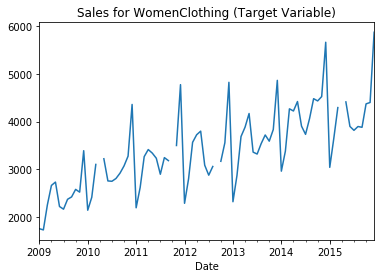

In [30]:
sales_data.plot()
plt.title("Sales for WomenClothing (Target Variable)")
plt.legend().remove()
plt.show()

In [31]:
# Interpolation on the missing values
sales_data.interpolate(method = 'linear', inplace=True)

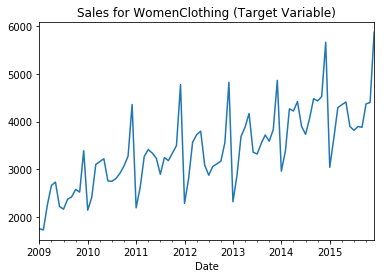

In [32]:
sales_data.plot()
plt.title("Sales for WomenClothing (Target Variable)")
plt.legend().remove()
plt.show()

## 3.2 Holidays Data

### 3.2.1 Checking for missing values in the data

In [33]:
holidays_data.isnull().sum()

Event          0
DayCategory    0
dtype: int64

In [34]:
# Printing the statistics of the holidays data
holidays_data.describe(include='all')

,Event,DayCategory
count,150,150
unique,23,2
top,Martin Luther King Jr. Day,Federal Holiday
freq,8,88


In [35]:
holidays_data.tail()

,Event,DayCategory
Date,,
2016-11-24,Thanksgiving Day,Federal Holiday
2016-12-24,Christmas Eve,Event
2016-12-25,Christmas Day,Federal Holiday
2016-12-26,'Christmas Day' observed,Federal Holiday
2016-12-31,New Year's Eve,Event


### 3.2.2. Resampling the data 

In [36]:
# Converting 'Events' as 1 and 'Federal Holiday' as 4
holidays_data['DayCategory'] = holidays_data['DayCategory'].map({'Event':1, 'Federal Holiday':4})
holidays_data = holidays_data.resample('M').sum()
holidays_data.DayCategory.fillna(value= 0, inplace = True)

## 3.3 Macroeconomic Data

In [37]:
print("The first 5 instances from the table:")
economic_data.head()

The first 5 instances from the table:


,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
Date,,,,,,,,,,,,,,,
2009-01-01,14421.752895,14407.053343,233.402,7.8,12.03,11.44,22.05,57.70,4.02,9.296,7.559,799,12.589,4.17,11.550
2009-02-01,14389.200466,14366.176571,234.663,8.3,12.97,11.05,22.22,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.100
2009-03-01,14340.701639,14351.786822,235.067,8.7,12.97,11.05,22.22,51.50,-6.72,9.296,7.559,799,12.589,3.72,11.650
2009-04-01,14326.815525,14351.601731,235.582,9.0,12.97,11.05,22.13,56.78,10.25,9.296,7.559,787,12.400,3.62,12.225
2009-05-01,14345.904809,14368.123959,235.975,9.4,13.32,11.25,22.04,61.95,9.11,9.297,7.400,803,12.384,3.52,12.300


### 3.3.1 Checking for missing values in the data

In [38]:
economic_data.isnull().sum()

Monthly Nominal GDP Index (inMillion$)                               0
Monthly Real GDP Index (inMillion$)                                  0
CPI                                                                  0
unemployment rate                                                    0
CommercialBankInterestRateonCreditCardPlans                          0
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan    0
Earnings or wages  in dollars per hour                               0
Cotton Monthly Price - US cents per Pound(lbs)                       0
Change(in%)                                                          0
Average upland planted(million acres)                                0
Average upland harvested(million acres)                              0
yieldperharvested acre                                               0
Production (in  480-lb netweright in million bales)                  0
Mill use  (in  480-lb netweright in million bales)                   0
Export

### 3.3.2 Checking for Outliers in the data


 Standard Deviation of Monthly Nominal GDP Index (inMillion$)


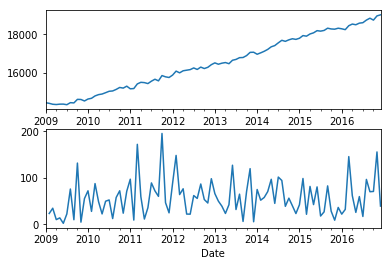


 Standard Deviation of Monthly Real GDP Index (inMillion$)


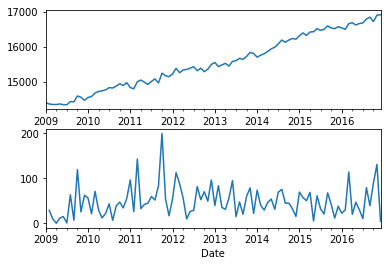


 Standard Deviation of CPI


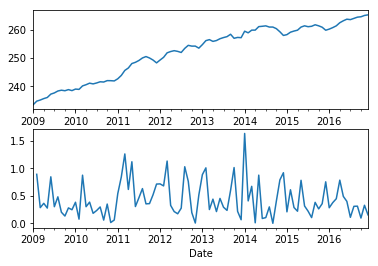


 Standard Deviation of unemployment rate


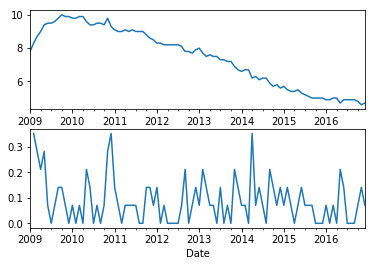


 Standard Deviation of CommercialBankInterestRateonCreditCardPlans


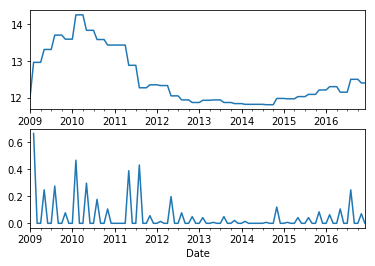


 Standard Deviation of Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan


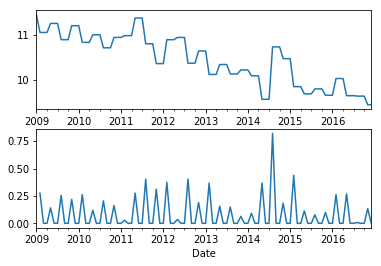


 Standard Deviation of Earnings or wages  in dollars per hour


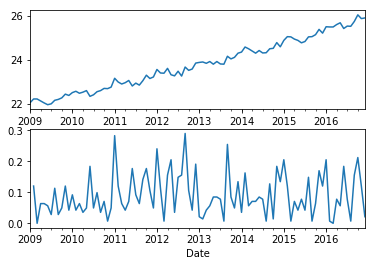


 Standard Deviation of Cotton Monthly Price - US cents per Pound(lbs)


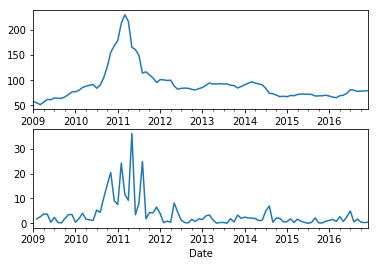


 Standard Deviation of Change(in%)


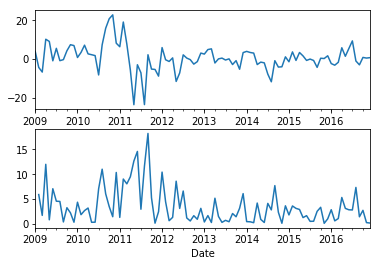


 Standard Deviation of Average upland planted(million acres)


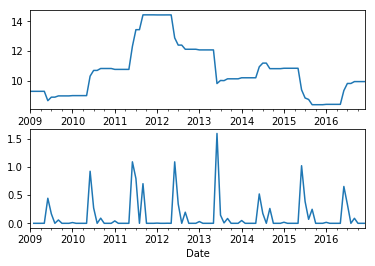


 Standard Deviation of Average upland harvested(million acres)


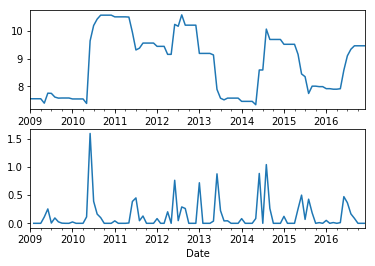


 Standard Deviation of yieldperharvested acre


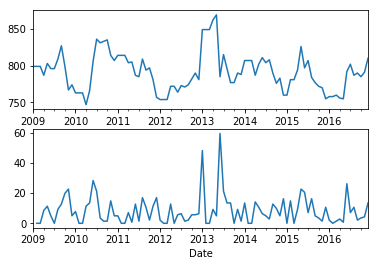


 Standard Deviation of Production (in  480-lb netweright in million bales)


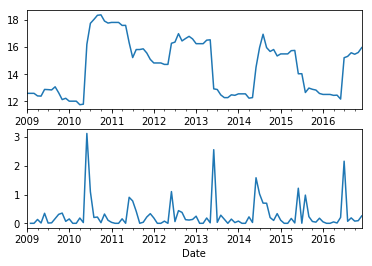


 Standard Deviation of Mill use  (in  480-lb netweright in million bales)


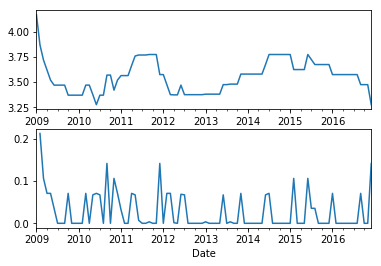


 Standard Deviation of Exports


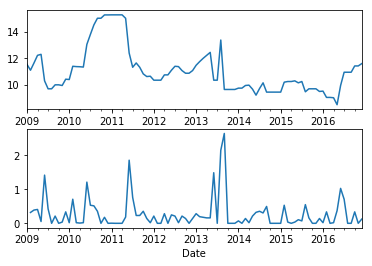

In [39]:
std_economic_data = pd.DataFrame()
for columns in economic_data.columns:
    std_economic_data[columns] = economic_data[columns].rolling(window=2,center=False).std()
    # economic_data[columns] = economic_data[columns].pct_change()
    
for columns in economic_data.columns: 
    print("\n","Standard Deviation of", columns)
    fig = plt.figure()   
    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1),(1,0))
    economic_data[columns].plot(ax=ax1)
    std_economic_data[columns].plot(ax=ax2)
    plt.legend().remove()
    plt.legend().remove()    
    plt.show()
    


## 3.4 Weather Data

### 3.4.1 Checking for non-numeric characters in numeric variables

In [40]:
# Converting the cells that have the value "T" to O.01
weather_data[weather_data.columns[18]] = weather_data[weather_data.columns[18]].apply(lambda x: 0.01 if x == 'T' else x)

In [41]:
# Converting all cells that have the value "-" to NaN
weather_data = weather_data.applymap(lambda x: np.nan if x == '-' else x)

In [42]:
# Replacing the missing values in 'WeatherEvent' column to "NA"
weather_data.WeatherEvent.fillna(value="NotApplicable", inplace=True)

# Droping the two rows having all columns as NaN
weather_data = weather_data[~weather_data["Temp high (°C)"].isnull()]

In [43]:
weather_data.describe(include='all')

,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) low,Visibility (km) high,Visibility (km) avg,Visibility (km) low,Wind (km/h) low,Wind (km/h) avg,Wind (km/h) high,Precip. (mm) sum,WeatherEvent
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2903.000000,2903.000000,2903.000000,2894.000000,2894.000000,2894.000000,2902.000000,2902.000000,2863.000000,2920.000000,2920
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotApplicable
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1906
mean,17.371918,13.530137,9.429452,8.503767,5.366096,1.854110,77.907192,61.460616,44.522945,1019.838099,1016.218739,1012.660007,15.895646,13.909468,10.449896,23.061682,9.092695,36.004191,3.454425,NaN
std,10.230641,9.662644,9.322538,10.045084,10.509162,10.993565,15.637223,14.433762,15.827029,7.054331,7.429849,7.980106,0.618441,3.157808,6.142232,7.262782,4.883618,10.772405,9.851643,NaN
min,-9.000000,-14.000000,-18.000000,-24.000000,-27.000000,-28.000000,28.000000,20.000000,9.000000,994.000000,980.000000,966.000000,8.000000,1.000000,0.000000,6.000000,0.000000,11.000000,0.000000,NaN
25%,9.000000,6.000000,2.000000,1.000000,-3.000000,-7.000000,65.000000,51.000000,33.000000,1015.000000,1012.000000,1008.000000,16.000000,13.000000,3.000000,19.000000,6.000000,27.000000,0.000000,NaN
50%,18.000000,14.000000,10.000000,10.000000,6.000000,2.000000,79.000000,61.000000,42.000000,1020.000000,1016.000000,1013.000000,16.000000,16.000000,14.000000,23.000000,8.000000,35.000000,0.000000,NaN
75%,26.000000,22.000000,18.000000,17.000000,14.000000,11.000000,93.000000,72.000000,54.000000,1024.000000,1021.000000,1018.000000,16.000000,16.000000,16.000000,26.000000,11.000000,42.000000,1.270000,NaN


### 3.4.1 Checking for missing vales in the data

In [44]:
weather_data.isnull().sum()

Temp high (°C)                  0
Temp avg (°C)                   0
Temp low (°C)                   0
Dew Point high (°C)             0
Dew Point avg (°C)              0
Dew Point low (°C)              0
Humidity (%) high               0
Humidity (%) avg                0
Humidity (%) low                0
Sea Level Press. (hPa) high    17
Sea Level Press. (hPa) avg     17
Sea Level Press. (hPa) low     17
Visibility (km) high           26
Visibility (km) avg            26
Visibility (km) low            26
Wind (km/h) low                18
Wind (km/h) avg                18
Wind (km/h) high               57
Precip. (mm) sum                0
WeatherEvent                    0
dtype: int64

### 3.4.3 Calculating the correlation of each variables

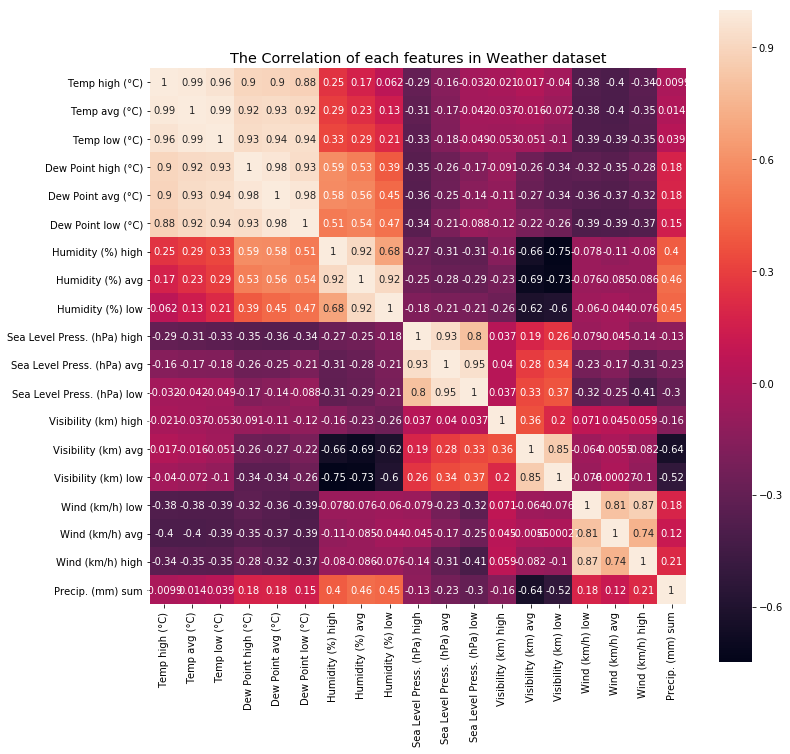

In [45]:
correlation_weather = weather_data.corr()

### Ploting the correlation 
%matplotlib inline
plt.figure(figsize =(12,12))
sns.heatmap(data= correlation_weather, annot =True, square= True)
plt.title('The Correlation of each features in Weather dataset', fontsize= 'x-large')
plt.show()

In [46]:
weather_data.dtypes

Temp high (°C)                 float64
Temp avg (°C)                  float64
Temp low (°C)                  float64
Dew Point high (°C)            float64
Dew Point avg (°C)             float64
Dew Point low (°C)             float64
Humidity (%) high              float64
Humidity (%) avg               float64
Humidity (%) low               float64
Sea Level Press. (hPa) high    float64
Sea Level Press. (hPa) avg     float64
Sea Level Press. (hPa) low     float64
Visibility (km) high           float64
Visibility (km) avg            float64
Visibility (km) low            float64
Wind (km/h) low                float64
Wind (km/h) avg                float64
Wind (km/h) high               float64
Precip. (mm) sum               float64
WeatherEvent                    object
dtype: object

### 3.4.3 Checking for Outliers in the data


 Standard Deviation of Temp high (°C)


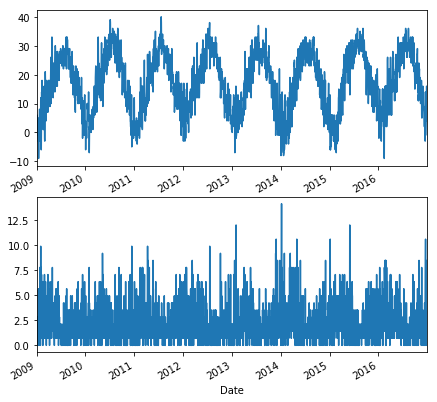


 Standard Deviation of Temp avg (°C)


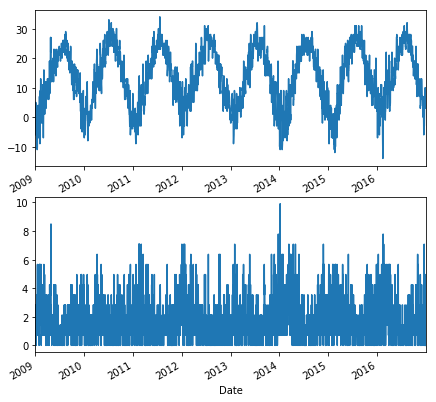


 Standard Deviation of Temp low (°C)


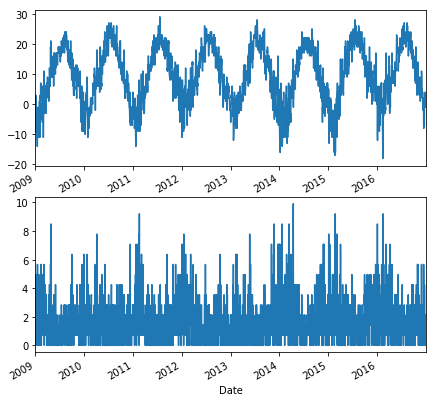


 Standard Deviation of Dew Point high (°C)


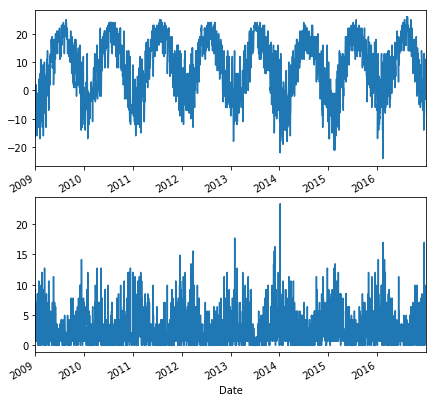


 Standard Deviation of Dew Point avg (°C)


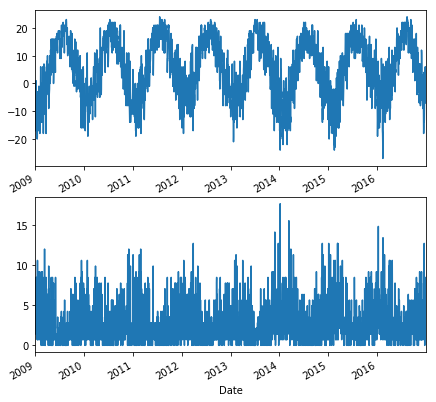


 Standard Deviation of Dew Point low (°C)


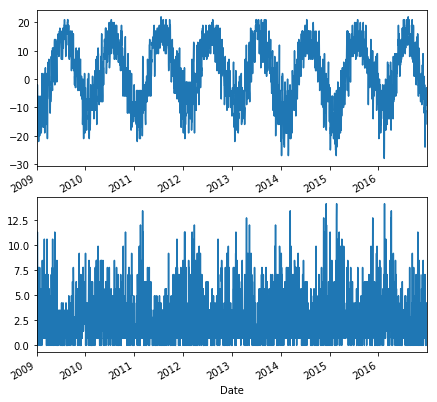


 Standard Deviation of Humidity (%) high


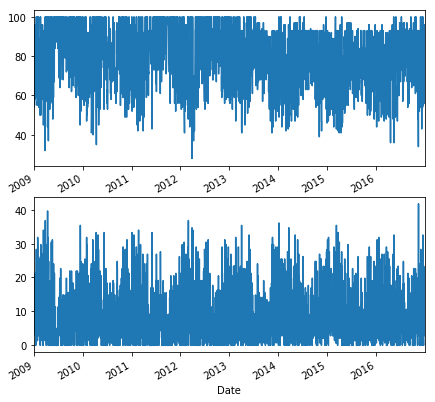


 Standard Deviation of Humidity (%) avg


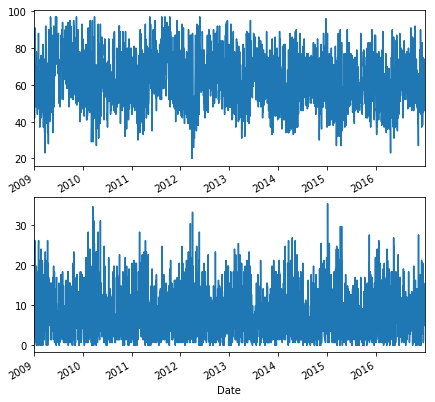


 Standard Deviation of Humidity (%) low


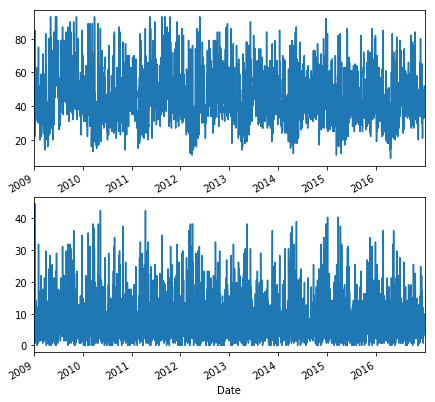


 Standard Deviation of Sea Level Press. (hPa) high


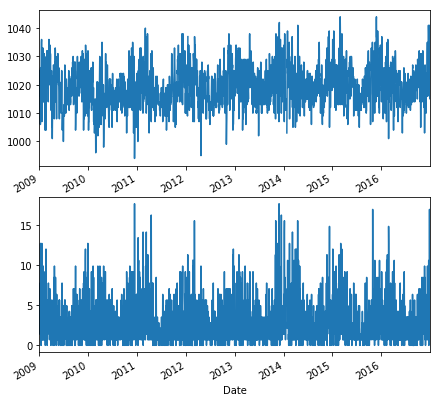


 Standard Deviation of Sea Level Press. (hPa) avg


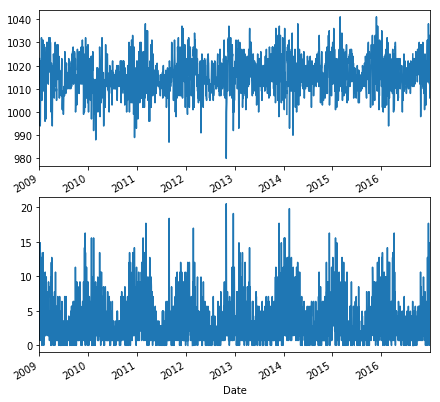


 Standard Deviation of Sea Level Press. (hPa) low


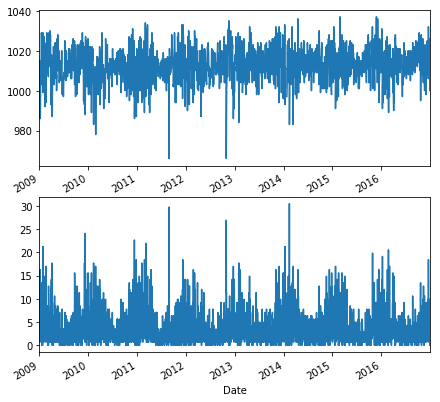


 Standard Deviation of Visibility (km) high


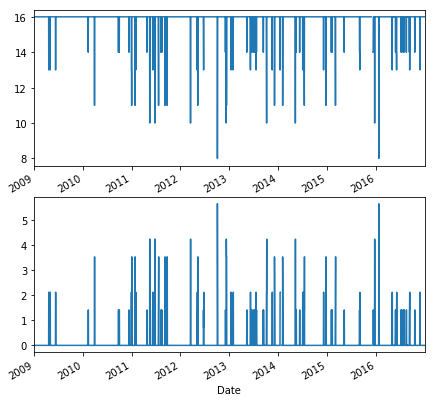


 Standard Deviation of Visibility (km) avg


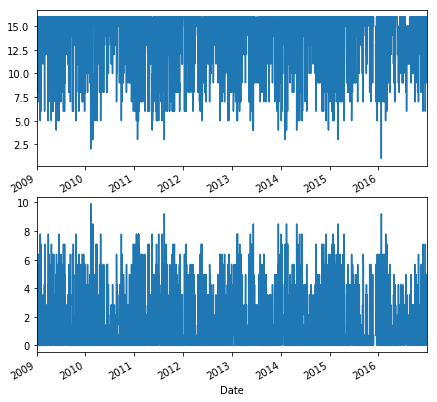


 Standard Deviation of Visibility (km) low


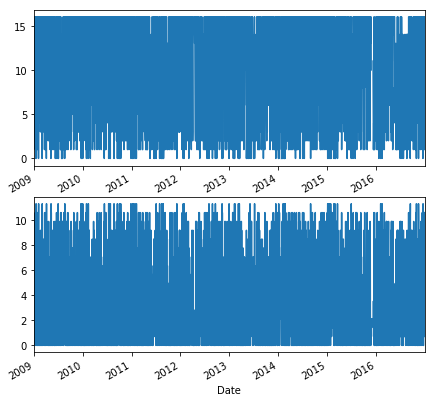


 Standard Deviation of Wind (km/h) low


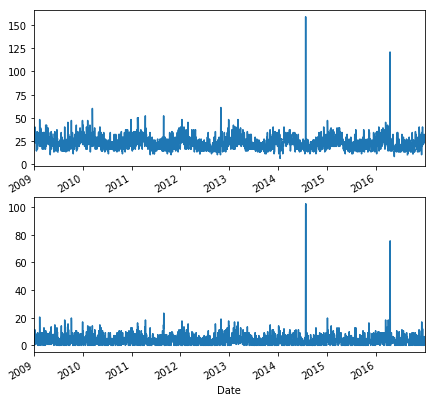


 Standard Deviation of Wind (km/h) avg


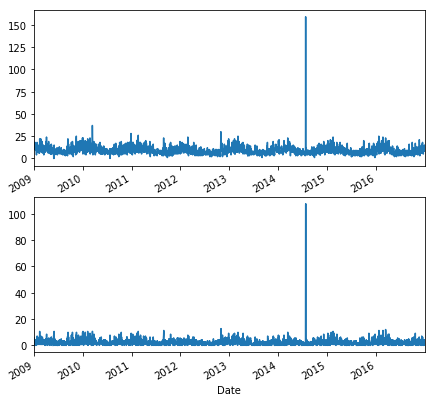


 Standard Deviation of Wind (km/h) high


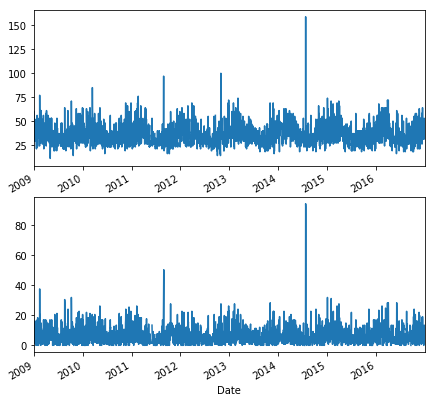


 Standard Deviation of Precip. (mm) sum


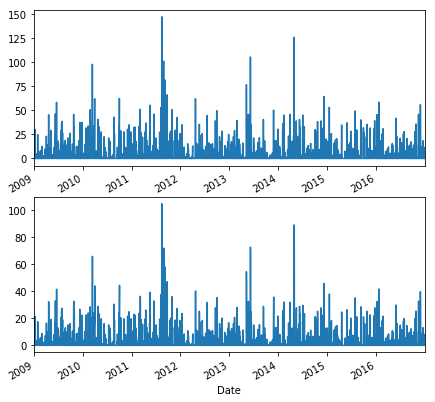

In [47]:
std_weather_data = pd.DataFrame()
for columns in weather_data.iloc[:,0:19].columns:
    std_weather_data[columns] = weather_data[columns].rolling(window=2,center=False).std()
    
for columns in weather_data.iloc[:,0:19].columns: 
    print("\n","Standard Deviation of", columns)
    fig = plt.figure(figsize=(7,7))   
    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1),(1,0))
    weather_data[columns].plot(ax=ax1)
    std_weather_data[columns].plot(ax=ax2)
    plt.legend().remove()
    plt.legend().remove()    
    plt.show()

In [48]:
### 3.4.4 Converting 'WeatherEvent' into dummy variables
weather_dummies = pd.get_dummies(weather_data.WeatherEvent, prefix='WeatherEvent')
weather_dummies.drop(weather_dummies.columns[8],1, inplace = True)
weather_data = pd.concat([weather_data, weather_dummies], axis =1)
weather_data.drop(weather_data.columns[19],1, inplace = True)

In [49]:
# Resampling the weather data with the mean of each month
weather_data_mean = weather_data.resample('M').mean()

# 4. Merging the Dataframes

In [50]:
# Synchronising the index before merging
holidays_data.index = economic_data.index
weather_data_mean.index = economic_data.index

merged_data = economic_data.join(weather_data_mean)
merged_data = merged_data.join(holidays_data)

In [51]:
merged_data.to_csv("preprocessed_merged_data.csv")

# 5. Splitting the data into Train, Test and Validation

## 5.1. Splitting the Target Variable into Train and Validation

In [52]:
split_validation_time = pd.to_datetime('2015-01-01')
split_test_time = pd.to_datetime('2016-01-01')
sales_data.drop(sales_data.columns[0],1,inplace = True)
target_validation = sales_data.loc[sales_data.index >= split_validation_time]
target_train = sales_data.loc[sales_data.index < split_validation_time]

## 5.2. Spliting the merged data into Train, Validation and Test

In [53]:
merged_test = merged_data.loc[merged_data.index >= split_test_time]
merged_validation = merged_data.loc[(merged_data.index >= split_validation_time) \
                                             & (merged_data.index < split_test_time)]
merged_train = merged_data.loc[merged_data.index < split_validation_time]

# 6. Comparing the features

## 6.1. Identifing Feature Importance using ANOVA 

In [54]:
sel = SelectKBest(k =5, score_func = f_regression)
sel.fit(merged_train, target_train)

C:\Users\Thomas\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=5, score_func=<function f_regression at 0x00000272E8D2EA60>)

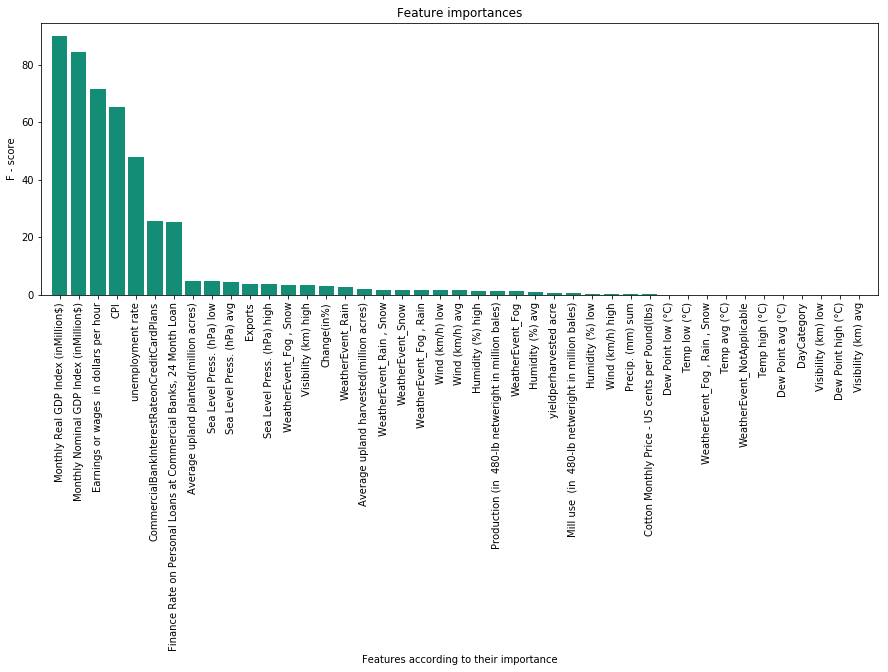

In [55]:
important_features = []
importances = sel.scores_
indices = np.argsort(importances)[::-1]
for f in range(merged_train.shape[1]):    
    important_features = np.append(important_features, merged_train.columns.values[indices[f]])
    
plt.figure(figsize =(15,5))
plt.title("Feature importances")
plt.bar(range(merged_train.shape[1]), importances[indices],
       color="#138D75", align="center")
plt.xticks(range(merged_train.shape[1]), important_features, rotation = 90)
plt.xlim([-1, merged_train.shape[1]])
plt.ylabel('F - score')
plt.xlabel('Features according to their importance')
plt.show()

## 6.2. Checking for Multicolinearity using Variable Inflation Factor (VIF)

In [56]:
x_var = merged_train
y_var = target_train
x_var_names = merged_train.columns
for i in range(0, len(x_var_names)):
    y = x_var[x_var_names[i]]
    x = x_var[x_var_names.drop(x_var_names[i])]
    lr1 = LinearRegression()
    rsq = lr1.fit(x,y).score(x,y)
    vif = round(1/(1-rsq),2)
    print (x_var_names[i], " VIF = " , vif)


Monthly Nominal GDP Index (inMillion$)  VIF =  7354.23
Monthly Real GDP Index (inMillion$)  VIF =  2762.54
CPI  VIF =  722.8
unemployment rate  VIF =  196.72
CommercialBankInterestRateonCreditCardPlans  VIF =  29.37
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan  VIF =  7.65
Earnings or wages  in dollars per hour  VIF =  157.48
Cotton Monthly Price - US cents per Pound(lbs)  VIF =  14.09
Change(in%)  VIF =  4.1
Average upland planted(million acres)  VIF =  11.11
Average upland harvested(million acres)  VIF =  425.24
yieldperharvested acre  VIF =  28.39
Production (in  480-lb netweright in million bales)  VIF =  499.07
Mill use  (in  480-lb netweright in million bales)  VIF =  10.51
Exports  VIF =  12.79
Temp high (°C)  VIF =  14787.69
Temp avg (°C)  VIF =  51237.89
Temp low (°C)  VIF =  15049.01
Dew Point high (°C)  VIF =  2956.84
Dew Point avg (°C)  VIF =  4524.26
Dew Point low (°C)  VIF =  2476.58
Humidity (%) high  VIF =  7516.24
Humidity (%) avg  VIF =  27894.56


# 7. Building Models

## 7.1 Linear Regression Model

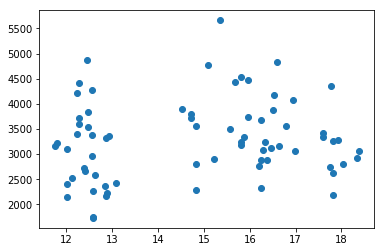

In [57]:
plt.scatter(merged_train[merged_train.columns[12]], target_train["Sales(In ThousandDollars)"])
plt.show()

-0.517847851408


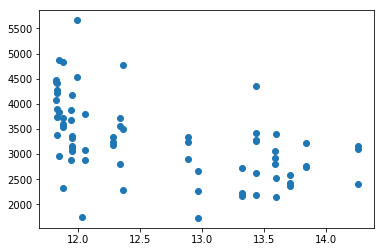

In [58]:
plt.scatter(merged_train[merged_train.columns[4]], target_train["Sales(In ThousandDollars)"])
print(merged_train[merged_train.columns[4]].corr(target_train["Sales(In ThousandDollars)"]))

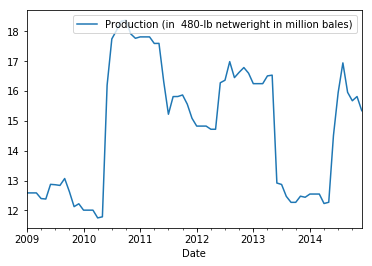

In [59]:
merged_train.loc[:,[merged_train.columns[12]]].plot()
plt.show()

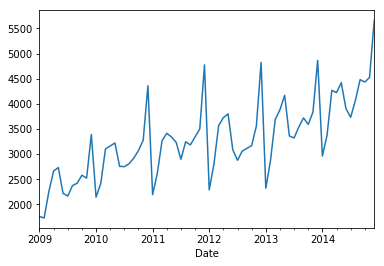

In [60]:
target_train["Sales(In ThousandDollars)"].plot()
plt.show()

In [61]:
model = OLS(target_train,merged_train).fit()
ols_predicted_train = model.predict(merged_train)
print(model.summary())

                                OLS Regression Results                               
Dep. Variable:     Sales(In ThousandDollars)   R-squared:                       0.989
Model:                                   OLS   Adj. R-squared:                  0.973
Method:                        Least Squares   F-statistic:                     61.66
Date:                       Sun, 26 Nov 2017   Prob (F-statistic):           7.09e-20
Time:                               16:13:53   Log-Likelihood:                -524.31
No. Observations:                         72   AIC:                             1135.
Df Residuals:                             29   BIC:                             1233.
Df Model:                                 43                                         
Covariance Type:                   nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
------

In [62]:
print(mean_absolute_percentage_error(target_train, ols_predicted_train))

26.9818291327


In [63]:
ols_predicted_validation = model.predict(merged_validation)

In [64]:
print(mean_absolute_percentage_error(target_validation, ols_predicted_validation))

37.9081812406


### Checking for the Residuals v/s Fitted Y

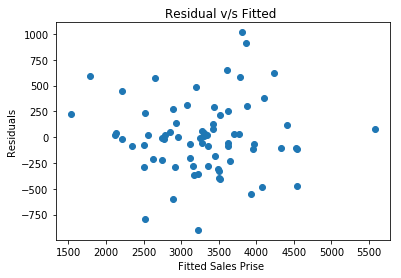

In [65]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Sales Prise ')
plt.ylabel('Residuals')
plt.title('Residual v/s Fitted ')
plt.show()

### Checking for Hetroscedasticity

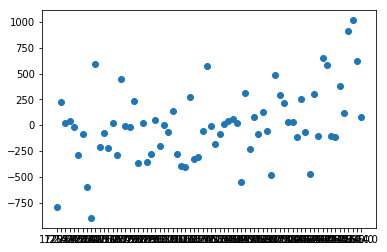

In [66]:
# Heteroscedasticity
plt.scatter(target_train,model.resid)
plt.show()

## 7.2 ElasticNetCV

In [67]:
X_train = np.array(merged_train)
X_train = preprocessing.scale(X_train)

X_val = np.array(merged_validation) 
X_val = preprocessing.scale(X_val)

X_test = np.array(merged_test)
X_test = preprocessing.scale(merged_test)

Y_train = np.array(target_train[target_train.columns[0]]).ravel()
Y_val = np.array(target_validation[target_validation.columns[0]]).ravel()

In [68]:

from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(copy_X=True, cv=20, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)
elastic_predicted_train = regr.fit(X_train,Y_train).predict(X_train)
print(mean_absolute_percentage_error(Y_train,elastic_predicted_train))
elastic_predicted_val = regr.predict(X_val)
print(mean_absolute_percentage_error(Y_val,elastic_predicted_val))
elastic_predicted_test = regr.predict(X_test)

11.9625829592
20.0481391264


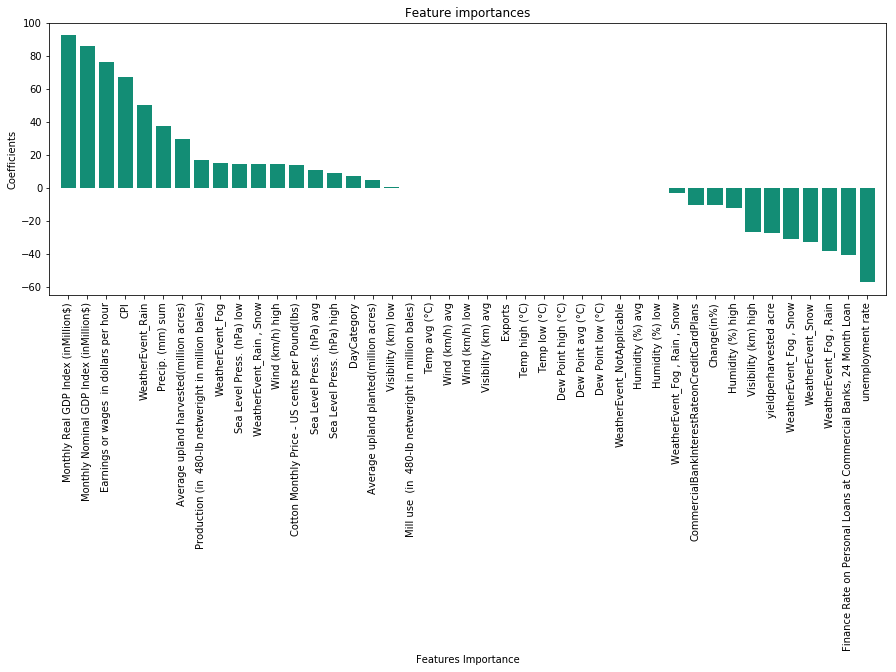

In [69]:
important_features = []
importances = regr.coef_
indices = np.argsort(importances)[::-1]
for f in range(merged_train.shape[1]):    
    important_features = np.append(important_features, merged_train.columns.values[indices[f]])
    
plt.figure(figsize =(15,5))
plt.title("Feature importances")
plt.bar(range(merged_train.shape[1]), importances[indices],
       color="#138D75", align="center")
plt.xticks(range(merged_train.shape[1]), important_features, rotation = 90)
plt.xlim([-1, merged_train.shape[1]])
plt.ylabel('Coefficients')
plt.xlabel('Features Importance')
plt.show()

In [70]:
elastic_predicted_test = pd.DataFrame(elastic_predicted_test)

In [71]:
### Reading the template file 
final_result = pd.read_csv("template.csv")

final_result = final_result.loc[final_result.ProductCategory == "WomenClothing",].copy()

final_result.drop("target",1, inplace= True )
final_result = final_result.join(elastic_predicted_test)
final_result = final_result.rename(columns = {final_result.columns[3]:'target'})

final_result.to_csv("prediction-elasticnet.csv")

## 7.3 Support Vector Machines

In [72]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)

parameter_values = [
  {'C': [35, 40, 50, 60, 70, 80, 90], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], \
   'kernel': ['rbf'], 'degree':[1, 2, 3]},
  {'C': [35, 40, 50, 60, 70, 80, 90], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],\
   'kernel': ['poly'], 'degree':[1,2, 3, 4]},
  {'C': [35, 40, 50, 60, 70, 80, 90], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],\
   'kernel': ['linear'], 'degree':[1,2, 3, 4]}
]
svr_grid = GridSearchCV(estimator= SVR(), param_grid=parameter_values, n_jobs=-1)


Y_predicted_train_rbf = svr_rbf.fit(X_train,Y_train).predict(X_train)
Y_predicted_train_lin = svr_lin.fit(X_train,Y_train).predict(X_train)
Y_predicted_train_grid = svr_grid.fit(X_train,Y_train).predict(X_train)

print(mean_absolute_percentage_error(Y_train,Y_predicted_train_rbf))
print(mean_absolute_percentage_error(Y_train,Y_predicted_train_lin))
print(mean_absolute_percentage_error(Y_train,Y_predicted_train_grid))

1.64492610964
7.54982746538
10.709251259


In [73]:
Y_predicted_validation_rbf = svr_rbf.fit(X_train,Y_train).predict(X_val)
Y_predicted_validation_lin = svr_lin.fit(X_train,Y_train).predict(X_val)
Y_predicted_validation_grid = svr_grid.fit(X_train,Y_train).predict(X_val)

print(mean_absolute_percentage_error(Y_val,Y_predicted_validation_rbf.ravel()))
print(mean_absolute_percentage_error(Y_val,Y_predicted_validation_lin.ravel()))
print(mean_absolute_percentage_error(Y_val,Y_predicted_validation_grid.ravel()))

20.0387855479
29.8213388858
20.4509680696


## 7.4 RandomForest

In [74]:
# RandomForest with cross validation
parameter_value = [
  {'n_estimators': [75], 'max_features': [9, 20, 25],'oob_score' : [True], 'criterion' : ['mae'], 'max_depth': [60, 75, 80], 'min_samples_leaf':[1]}
]
rf_grid = GridSearchCV(estimator= RandomForestRegressor(),param_grid=parameter_value, n_jobs=-1)

rf_grid_predicted_train = rf_grid.fit(merged_train,target_train).predict(merged_train)

print(mean_absolute_percentage_error(target_train,rf_grid_predicted_train))
rf_grid_predicted_val = rf_grid.predict(merged_validation)
print(mean_absolute_percentage_error(target_validation,rf_grid_predicted_val))

C:\Users\Thomas\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


26.4791169291
14.5133094642


In [75]:
rf_grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=80,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=75, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [76]:
rf_grid_predicted_test = rf_grid.predict(merged_test)
rf_grid_predicted_test = pd.DataFrame(rf_grid_predicted_test)

In [77]:
### Reading the template file 
final_result = pd.read_csv("template.csv")

final_result = final_result.loc[final_result.ProductCategory == "WomenClothing",].copy()

final_result.drop("target",1, inplace= True )
final_result = final_result.join(rf_grid_predicted_test)
final_result = final_result.rename(columns = {final_result.columns[3]:'target'})

final_result.to_csv("prediction-rf-grid.csv")

In [78]:
# Random Forest
rf = RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=75,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
rf_predicted_train = rf.fit(merged_train,target_train).predict(merged_train)

print(mean_absolute_percentage_error(target_train,rf_predicted_train))
rf_predicted_val = rf.predict(merged_validation)
print(mean_absolute_percentage_error(target_validation,rf_predicted_val))

C:\Users\Thomas\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


26.4882283219
14.37205227


### Ranking the features based on their importance in the forest.

In [79]:
important_features = []
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("*************************************")
print("*                                   *")
print("*      Ranking of the features      *")
print("*                                   *")
print("*************************************")
for f in range(merged_train.shape[1]):
    print("%d. %s (%f)" % (f+1, merged_train.columns.values[indices[f]], importances[indices[f]]))
    important_features = np.append(important_features, merged_train.columns.values[indices[f]])

*************************************
*                                   *
*      Ranking of the features      *
*                                   *
*************************************
1. Monthly Real GDP Index (inMillion$) (0.140743)
2. Monthly Nominal GDP Index (inMillion$) (0.130897)
3. CPI (0.065103)
4. Earnings or wages  in dollars per hour (0.052644)
5. unemployment rate (0.050833)
6. Cotton Monthly Price - US cents per Pound(lbs) (0.037081)
7. DayCategory (0.022730)
8. Temp high (°C) (0.022630)
9. Sea Level Press. (hPa) low (0.022613)
10. Visibility (km) low (0.022041)
11. Change(in%) (0.020611)
12. Exports (0.020504)
13. Humidity (%) low (0.020389)
14. Sea Level Press. (hPa) high (0.020207)
15. WeatherEvent_NotApplicable (0.019419)
16. yieldperharvested acre (0.018794)
17. WeatherEvent_Rain (0.017857)
18. Dew Point low (°C) (0.017115)
19. Temp avg (°C) (0.016955)
20. Sea Level Press. (hPa) avg (0.016755)
21. Temp low (°C) (0.016150)
22. Wind (km/h) avg (0.015132)
23. Humid

### Plotting Feature importance with Random Forest model

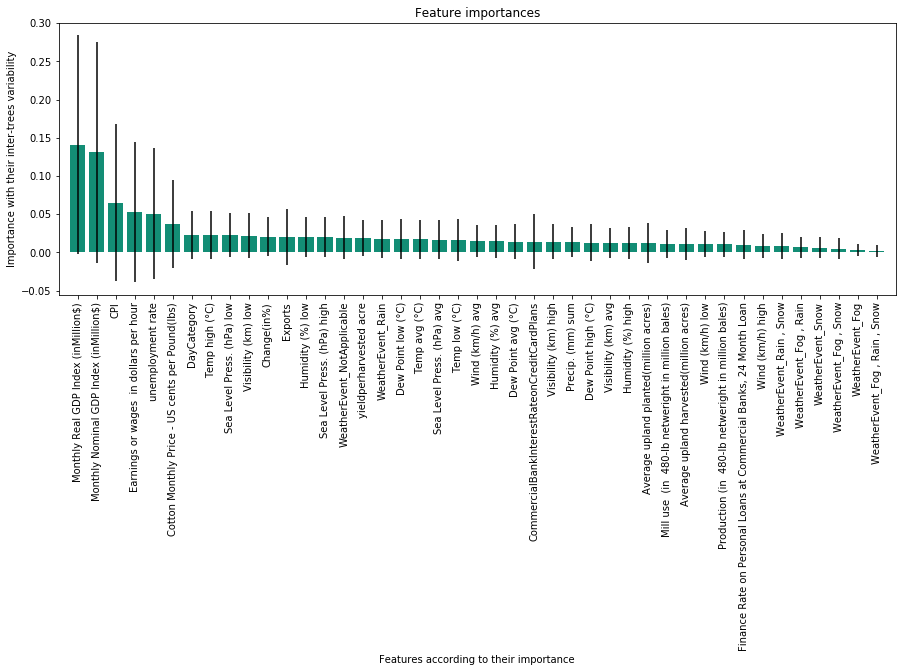

In [80]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
plt.figure(figsize =(15,5))
plt.title("Feature importances")
plt.bar(range(merged_train.shape[1]), importances[indices],
       color="#138D75", yerr=std[indices], align="center")
plt.xticks(range(merged_train.shape[1]), important_features, rotation = 90)
plt.xlim([-1, merged_train.shape[1]])
plt.ylabel('Importance with their inter-trees variability')
plt.xlabel('Features according to their importance')
plt.show()

In [81]:
rf_predicted_test = rf.predict(merged_test)
rf_predicted_test = pd.DataFrame(rf_predicted_test)

In [82]:
### Reading the template file 
final_result = pd.read_csv("template.csv")

final_result = final_result.loc[final_result.ProductCategory == "WomenClothing",].copy()

final_result.drop("target",1, inplace= True )
final_result = final_result.join(rf_predicted_test)
final_result = final_result.rename(columns = {final_result.columns[3]:'target'})

final_result.to_csv("prediction-rf.csv")